# Using JAX build 3 layer deep neural network for non linear regression

## Step 1: Import Libraries and Generate Synthetic Data

In [1]:
!pip install jax jaxlib optax matplotlib


In [2]:
import jax
import jax.numpy as jnp
from jax import random, grad
import optax
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def generate_data(size=1000):
    rng = random.PRNGKey(42)
    x = random.uniform(rng, (size, 3), minval=-3, maxval=3)
    y = jnp.sin(x[:, 0]) + x[:, 1]**2 - jnp.log(1 + jnp.abs(x[:, 2])) + random.normal(rng, (size,)) * 0.1
    return x, y.reshape(-1, 1)

x_np, y_np = generate_data()




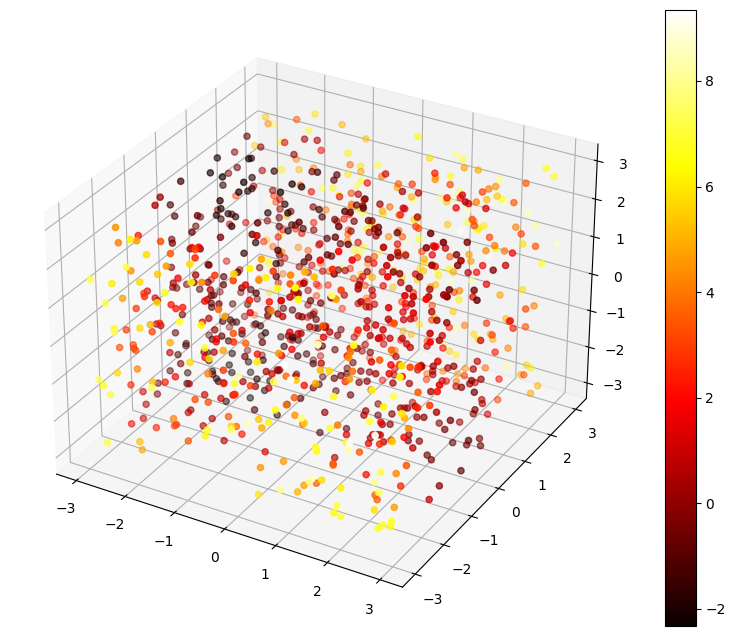

In [3]:
def plot_4d(x, y):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    p = ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=y.squeeze(), cmap=plt.hot())
    fig.colorbar(p)
    plt.show()

plot_4d(x_np, y_np)

## Step 2: Define the Neural Network

In [4]:
def init_network_params(layer_sizes, rng):
    params = []
    for n_in, n_out in zip(layer_sizes[:-1], layer_sizes[1:]):
        rng, key = random.split(rng)
        weights = random.normal(key, (n_in, n_out)) * jnp.sqrt(2/n_in)
        biases = jnp.zeros(n_out)
        params.append((weights, biases))
    return params

def relu(x):
    return jnp.maximum(0, x)

def predict(params, x):
    activations = x
    for w, b in params[:-1]:
        outputs = jnp.dot(activations, w) + b
        activations = relu(outputs)

    final_w, final_b = params[-1]
    y_pred = jnp.dot(activations, final_w) + final_b
    return y_pred


## Step 3: Training Loop

In [8]:
def mse_loss(params, x, y):
    preds = predict(params, x)
    return jnp.mean((preds - y) ** 2)

@jax.jit
def update(params, x, y, lr=0.01):
    grads = grad(mse_loss)(params, x, y)
    return [(w - lr * dw, b - lr * db) for (w, b), (dw, db) in zip(params, grads)]

# Initialize parameters and losses list
rng = random.PRNGKey(0)
layer_sizes = [3, 64, 64, 1]
params = init_network_params(layer_sizes, rng)
losses = []  # For logging

# Modified Training Loop with Loss Logging
epochs = 1000
for epoch in range(epochs):
    params = update(params, x_np, y_np, lr=0.001)
    loss = mse_loss(params, x_np, y_np)
    losses.append(loss)  # Log the loss

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')


Epoch 0, Loss: 11.716711044311523
Epoch 100, Loss: 1.2982702255249023
Epoch 200, Loss: 0.9812373518943787
Epoch 300, Loss: 0.8611004948616028
Epoch 400, Loss: 0.776263415813446
Epoch 500, Loss: 0.7120739817619324
Epoch 600, Loss: 0.6608451008796692
Epoch 700, Loss: 0.6185692548751831
Epoch 800, Loss: 0.5821942687034607
Epoch 900, Loss: 0.5507012009620667


## Step 4: Plot Training Loss and Actual vs. Predicted


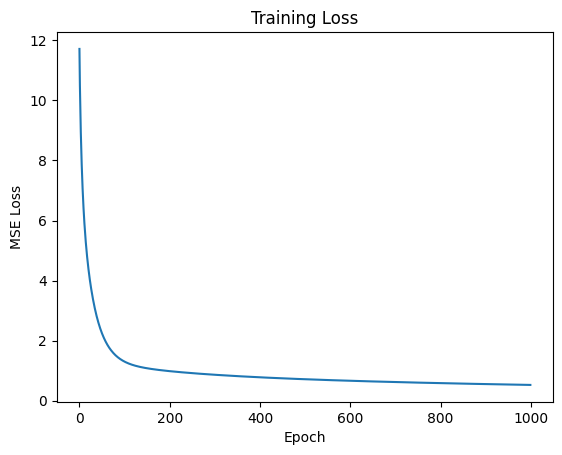

In [9]:
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()


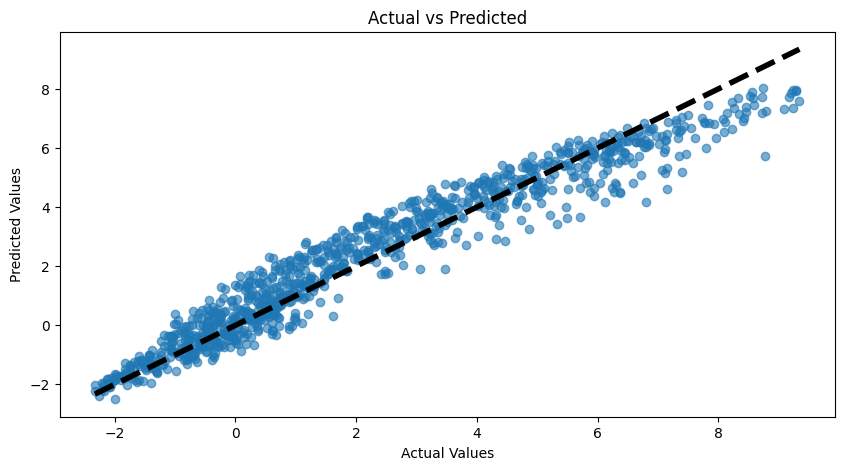

In [10]:
# Predictions using the trained model
preds = predict(params, x_np)

# Actual vs Predicted plot
plt.figure(figsize=(10, 5))
plt.scatter(y_np, preds, alpha=0.6)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted')
plt.plot([y_np.min(), y_np.max()], [y_np.min(), y_np.max()], 'k--', lw=4)
plt.show()
